In [45]:
import yaml
import torch
import argparse
import timeit
import numpy as np

import matplotlib.pyplot as plt

from torch.utils import data

from ptsemseg.models import get_model
from ptsemseg.loader import get_loader
from ptsemseg.metrics import runningScore
from ptsemseg.utils import convert_state_dict

torch.backends.cudnn.benchmark = True

In [51]:
def validate(cfg, args):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Setup Dataloader
    data_loader = get_loader(cfg["data"]["dataset"])
    data_path = cfg["data"]["path"]

    loader = data_loader(
        data_path,
        split=cfg["data"]["val_split"],
        is_transform=True,
        img_size=(cfg["data"]["img_rows"], cfg["data"]["img_cols"]),
    )

    n_classes = loader.n_classes

    valloader = data.DataLoader(loader, batch_size=cfg["training"]["batch_size"], num_workers=8)
    running_metrics = runningScore(n_classes)

    # Setup Model

    model = get_model(cfg["model"], n_classes).to(device)
    state = convert_state_dict(torch.load(args.model_path)["model_state"])
    model.load_state_dict(state)
    model.eval()
    model.to(device)
    
    for i, (images, labels) in enumerate(valloader):        
        
        start_time = timeit.default_timer()

        images = images.to(device)

        if args.eval_flip:
            outputs = model(images)

            # Flip images in numpy (not support in tensor)
            outputs = outputs.data.cpu().numpy()
            flipped_images = np.copy(images.data.cpu().numpy()[:, :, :, ::-1])
            flipped_images = torch.from_numpy(flipped_images).float().to(device)
            outputs_flipped = model(flipped_images)
            outputs_flipped = outputs_flipped.data.cpu().numpy()
            outputs = (outputs + outputs_flipped[:, :, :, ::-1]) / 2.0

            pred = np.argmax(outputs, axis=1)
            
        else:
            outputs = model(images)
            pred = outputs.data.max(1)[1].cpu().numpy()
                
        gt = labels.numpy()
        
        if args.measure_time:
            elapsed_time = timeit.default_timer() - start_time
            print(
                "Inference time \
                  (iter {0:5d}): {1:3.5f} fps".format(
                    i + 1, pred.shape[0] / elapsed_time
                )
            )
        
        running_metrics.update(gt, pred)

    score, class_iou = running_metrics.get_scores()

    bs = 2
    f, axarr = plt.subplots(bs, 2)
    for j in range(bs):
        #axarr[j][0].imshow(images[j])  
        axarr[j][1].imshow(pred[j])  
    plt.show()
 
    for k, v in score.items():
        print(k, v)

    for i in range(n_classes):
        print(i, class_iou[i])

In [52]:
class foo(object):
    def __init__(self):
        pass

my_args = foo()
my_args.model_path = "./runs/fcn8s_cityscapes/2019129_223213/fcn8s_cityscapes_best_model.pkl"
my_args.eval_flip = True
my_args.measure_time = True
print(f"args: {my_args.model_path}")

args: ./runs/fcn8s_cityscapes/2019129_223213/fcn8s_cityscapes_best_model.pkl


In [53]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Hyperparams")
    
    config_file = './configs/fcn8s_cityscapes.yml'
    
    with open(config_file) as fp:
        cfg = yaml.load(fp)
    print(cfg) # print to make sure it's loading correctly

{'model': {'arch': 'fcn8s'}, 'data': {'dataset': 'cityscapes', 'train_split': 'train', 'val_split': 'val', 'img_rows': 256, 'img_cols': 512, 'path': '/datasets/cityscapes/'}, 'training': {'train_iters': 85000, 'batch_size': 2, 'val_interval': 500, 'print_interval': 25, 'n_workers': 16, 'optimizer': {'name': 'sgd', 'lr': 1e-10, 'weight_decay': 0.0005, 'momentum': 0.99}, 'l_rate': 0.0001, 'l_schedule': None, 'loss': {'name': 'cross_entropy', 'size_average': False}, 'lr_schedule': None, 'momentum': 0.99, 'weight_decay': 0.0005, 'resume': 'frrnB_cityscapes_best_model.pkl', 'visdom': False}}


/home/jdchang/.conda/envs/py36-semseg/lib/python3.6/site-packages/ipykernel_launcher.py:7: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  import sys


In [54]:
import scipy
scipy.__version__

'1.0.1'

Found 500 val images
Inference time                   (iter     1): 9.88507 fps
Inference time                   (iter     2): 10.66736 fps
WARN: resizing labels yielded fewer classes
Inference time                   (iter     3): 14.07321 fps
Inference time                   (iter     4): 15.06579 fps
Inference time                   (iter     5): 14.99168 fps
Inference time                   (iter     6): 14.68121 fps
Inference time                   (iter     7): 14.88029 fps
Inference time                   (iter     8): 15.46628 fps
Inference time                   (iter     9): 15.26781 fps
Inference time                   (iter    10): 15.21375 fps
Inference time                   (iter    11): 14.15670 fps
Inference time                   (iter    12): 15.24058 fps
Inference time                   (iter    13): 14.97503 fps
Inference time                   (iter    14): 15.16560 fps
Inference time                   (iter    15): 15.25598 fps
Inference time                   (it

Inference time                   (iter   137): 15.10985 fps
Inference time                   (iter   138): 13.96206 fps
Inference time                   (iter   139): 14.08933 fps
Inference time                   (iter   140): 14.50103 fps
Inference time                   (iter   141): 15.00793 fps
Inference time                   (iter   142): 15.39624 fps
Inference time                   (iter   143): 14.66195 fps
Inference time                   (iter   144): 15.27557 fps
Inference time                   (iter   145): 15.21359 fps
Inference time                   (iter   146): 14.92167 fps
Inference time                   (iter   147): 14.89617 fps
Inference time                   (iter   148): 14.87549 fps
Inference time                   (iter   149): 15.18270 fps
Inference time                   (iter   150): 14.89726 fps
Inference time                   (iter   151): 14.95310 fps
Inference time                   (iter   152): 14.54539 fps
Inference time                   (iter  

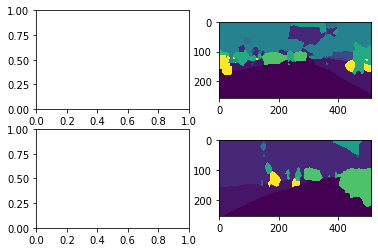

Overall Acc: 	 0.9138510029859098
Mean Acc : 	 0.6293917324797409
FreqW Acc : 	 0.8500549771234732
Mean IoU : 	 0.5401654544487696
0 0.9559156993440039
1 0.6897632524944372
2 0.8475458747930843
3 0.4507994736632242
4 0.363059455284627
5 0.24669065300969162
6 0.30451429404900815
7 0.39955030292094906
8 0.8592633102110727
9 0.5151626938772822
10 0.8866376742812035
11 0.5455986776471509
12 0.2332844168227712
13 0.8527431408429127
14 0.5290966084425746
15 0.4665587840601655
16 0.3412613689739101
17 0.2212448032777008
18 0.5544531505308518


In [55]:
validate(cfg, my_args)